In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from huber_regressor import RobustOnlineHuberRegressorGPU, DataPipeline, preprocess_data
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import cupy as cp
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 資料整理

In [2]:
df=pd.read_csv("dataset/house-prices-advanced-regression-techniques/train.csv")
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

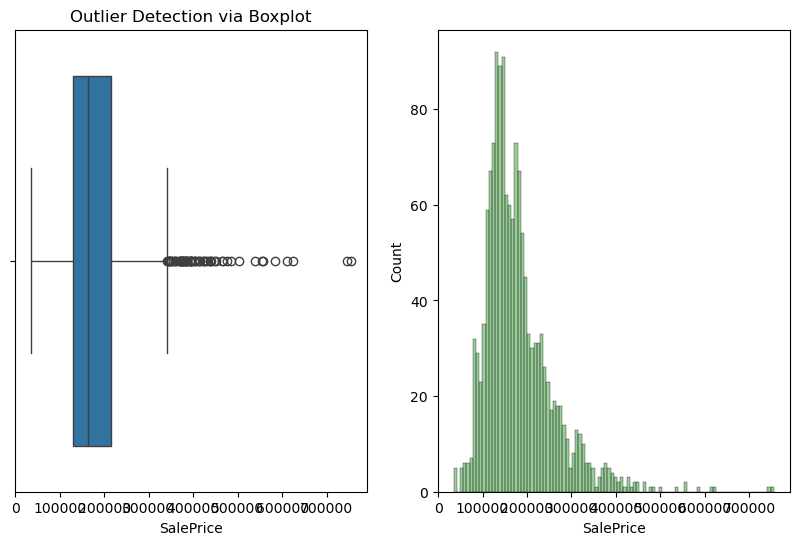

In [3]:
plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
sns.boxplot(x=df["SalePrice"])
plt.title("Outlier Detection via Boxplot")
plt.subplot(1,2,2)
sns.histplot(df['SalePrice'], color='g', bins=100, alpha=0.4)
plt.show()

In [4]:
categories = [
        'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
        'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
        'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
        'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
        'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
        'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
        'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',
        'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
        'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
        'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType',
        'SaleCondition'
    ]
df=preprocess_data(df, categories)

In [5]:
df = df.drop(columns=['Id', 'Alley', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'MiscVal'])
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(df.isnull().sum())
df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].mean())
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['GarageYrBlt'].mean())
df['MasVnrArea'] = df['MasVnrArea'].fillna(df['MasVnrArea'].mean())

# 訓練

In [6]:
X = df.drop(columns=['SalePrice'])
y = df['SalePrice']

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [8]:
# 4. 分割資料
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 5. 標準化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# 6. 資料驗證
X_train_scaled = cp.asarray(X_train_scaled)
assert not cp.any(cp.isnan(X_train_scaled)), "訓練集仍含NaN"
assert not cp.any(cp.isinf(X_train_scaled)), "訓練集含Inf"

# 3. 使用 Data Pipeline 訓練模型

In [9]:
print("Data Pipeline 訓練...")
batch_size = 50000

# 初始化模型
huber_model = RobustOnlineHuberRegressorGPU(
    k=1.345,
    fit_intercept=True, 
    reg_param=1e-4
)

# 初始化資料pipeline
pipeline = DataPipeline(X_train_scaled, y_train, batch_size)

# 啟動pipeline
start_time = time.time()
pipeline.start_pipeline()

# 主迴圈：GPU 運算與記憶體傳輸重疊
batch_count = 0
gpu_time = 0
prev_stream = None

while True:
    # 從佇列取得批次資料
    batch_data = pipeline.get_batch()
    if batch_data is None:
        break
        
    X_batch, y_batch, batch_id, stream = batch_data
    
    # 等待前一個批次的 GPU 運算完成（如果有的話）
    if prev_stream is not None:
        prev_stream.synchronize()
    
    # GPU 運算（使用當前批次的 stream，與下一批次的記憶體傳輸重疊）
    gpu_start = time.time()
    huber_model.fit_batch(X_batch, y_batch, stream)
    gpu_time += time.time() - gpu_start
        
    # 標記完成
    pipeline.mark_batch_done()
    batch_count += 1
    prev_stream = stream

Data Pipeline 訓練...
完成批次 1/1
資料準備執行緒完成


In [ ]:
# 等待最後一個批次完成
if prev_stream is not None:
    prev_stream.synchronize()

# 停止pipeline
pipeline.stop_pipeline()

# 完成模型
huber_model.finalize()

total_time = time.time() - start_time

訓練完成統計：
總時間: 30.22秒
GPU 運算時間: 0.19秒
GPU 使用時間佔比: 0.6%
處理批次數: 1
模型效能：
MAE: 21386.31
RMSE: 33992.66


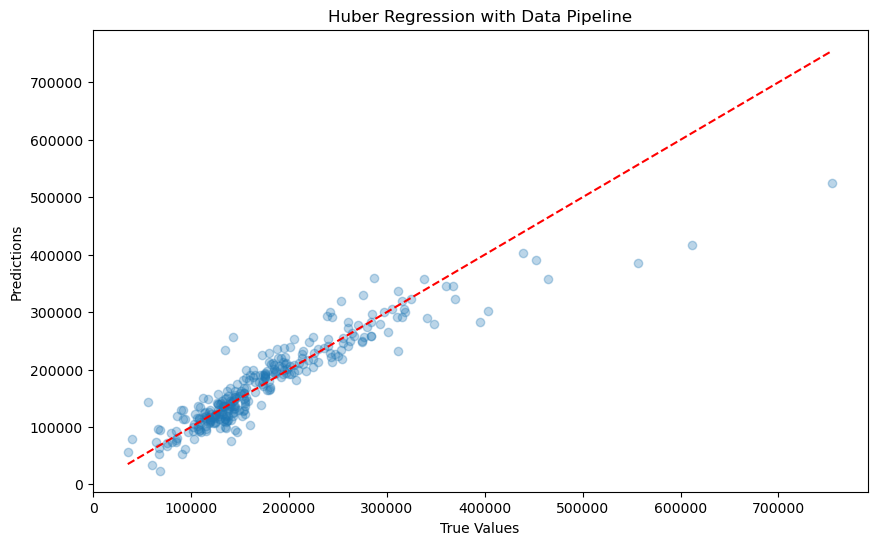

In [11]:
print(f"訓練完成統計：")
print(f"總時間: {total_time:.2f}秒")
print(f"GPU 運算時間: {gpu_time:.2f}秒")
print(f"GPU 使用時間佔比: {gpu_time/total_time*100:.1f}%")
print(f"處理批次數: {batch_count}")

# 8. 驗證模型
y_val_pred = huber_model.predict(X_val_scaled)

print(f"模型效能：")
print(f"MAE: {mean_absolute_error(y_val, y_val_pred):.2f}")
print(f"RMSE: {mean_squared_error(y_val, y_val_pred)**0.5:.2f}")

# 9. 視覺化結果
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_val_pred, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Huber Regression with Data Pipeline")
plt.show()